In [1]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push

!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 189 kB 48.5 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 44.5 MB/s 
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 86 kB/s 
     |████████████████████████████████| 561 kB 13.2 MB/s 
     |████████████████████████████████| 130 kB 39.4 MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


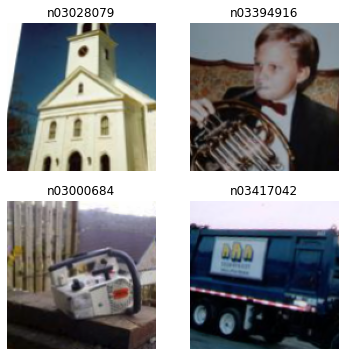

In [4]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n=4)

In [5]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c)
    )

SuggestedLRs(valley=0.0004786300996784121)

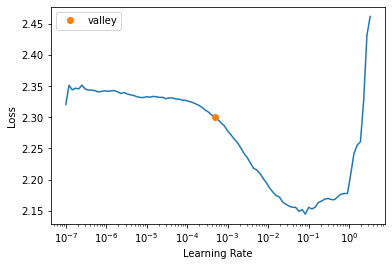

In [6]:
def get_learner(m):
    return Learner(dls, m, loss_func=nn.CrossEntropyLoss(),
                   metrics=accuracy).to_fp16()
learn = get_learner(get_model())
learn.lr_find()

In [7]:
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.865045,1.957713,0.393376,00:34
1,1.520623,1.409940,0.535796,00:35
2,1.290975,1.356211,0.578853,00:34
3,1.111461,1.047168,0.668280,00:34
4,1.021812,1.018307,0.680510,00:35


In [8]:
class ResBlock(Module):
    def __init__(self, ni, nf):
        self.convs = nn.Sequential(
            ConvLayer(ni, nf),
            ConvLayer(nf, nf, norm_type=NormType.Batch.Zero))
        
        def forward(self, x): return x + self.convs(x)

In [12]:
def _conv_block(ni, nf, stride):
    return nn.Sequential(
        ConvLayer(ni, nf, stride=stride),
        ConvLayer(nf, nf, act_cls=None, norm_type=NormType.BatchZero))

class ResBlock(Module):
    def __init__(self, ni, nf, stride=1):
        self.convs = _conv_block(ni, nf, stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
    
    def forward(self, x):
        return F.relu(self.convs(x) + self.idconv(self.pool(x)))

In [13]:
def block(ni, nf): return ResBlock(ni, nf, stride=2)
learn = get_learner(get_model())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.280587,2.204883,0.211720,00:39
1,2.141418,2.062383,0.297834,00:38
2,2.046708,1.994025,0.326115,00:38
3,1.993317,1.966426,0.330701,00:38
4,1.971265,1.962967,0.337834,00:38


In [15]:
def _resnet_stem(*sizes):
    return [
            ConvLayer(sizes[i], sizes[i+1], 3, stride=2 if i==0 else 1)
            for i in range(len(sizes)-1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
_resnet_stem(3, 32, 32, 64)

[ConvLayer(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), ConvLayer(
   (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
 ), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)]

In [18]:
class ResNet(nn.Sequential):
    def __init__(self, n_out, layers, expansion=1):
        stem = _resnet_stem(3,32,32,64)
        self.block_szs = [64, 64, 128, 128, 512]
        for i in range(1,5): self.block_szs[i] *= expansion
        blocks = [self._make_layer(*o) for o in enumerate(layers)]
        super().__init__(*stem, *blocks, nn.AdaptiveAvgPool2d(1), Flatten(),
                         nn.Linear(self.block_szs[-1], n_out))

    
    def _make_layer(self, idx, n_layers):
        stride = 1 if idx==0 else 2
        ch_in, ch_out = self.block_szs[idx:idx+2]
        return nn.Sequential(*[
                               ResBlock(ch_in if i==0 else ch_out, ch_out, stride if i==0 else 1)
                               for i in range(n_layers)
        ])

In [19]:
rn = ResNet(dls.c, [2,2,2,2])

In [20]:
learn = get_learner(rn)
learn.fit_one_cycle(5, 3e-3)


epoch,train_loss,valid_loss,accuracy,time
0,2.237665,2.131586,0.249682,00:48
1,2.029434,1.935975,0.341656,00:45
2,1.893731,1.845935,0.387771,00:44
3,1.814691,1.803621,0.414522,00:44
4,1.781377,1.804840,0.411975,00:44


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

!git config --global user.email 'intaek428@gmail.com'
!git config --global user.name 'ITHwang'

!git add .
!git commit -m ''
!git push